In [1]:
# imports
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

# constants
light_threshold = 127
light_cutoff = 16
saturation_threshold = 50
saturation_weight = 9
snap_range = 32
countour_area = 90000

In [2]:
# calculate average lightness of an hls image
def getAverageLightness(img_hls, mask):
    l_channel = img_hls[:,:,1]
    return l_channel[mask].sum() / mask.sum()

# check if a pixel is grayscale or close
def isGrayscale(saturation, light):
    if saturation < saturation_threshold:
        return True
    if light < light_cutoff or light > (255 - light_cutoff):
        return True
    return False

# take an rgb image and convert it to dark mode
def emulateDarkMode(img_rgb, mask):
    img_tmp = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    for x in range(img_tmp.shape[0]):
        for y in range(img_tmp.shape[1]):
            if mask[x][y]:
                sat_val = img_tmp[x][y][2]
                old_val = img_tmp[x][y][1]
                dark_val = 255 if old_val == 0 else min(255, 1000000 / math.pow(old_val, 2))

                # if saturation is abolve a certain level, boost the value to avoid dimming
                if not isGrayscale(sat_val, old_val):
                    dark_val = (dark_val + (old_val * saturation_weight)) / (2 + saturation_weight)

                img_tmp[x][y][1] = dark_val

    return cv2.cvtColor(img_tmp, cv2.COLOR_HLS2RGB)

# take a generally dark image and go more extreme
def improveContrast(img_rgb, mask):
    img_tmp = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    for x in range(img_tmp.shape[0]):
        for y in range(img_tmp.shape[1]):
            if mask[x][y]:
                sat_val = img_tmp[x][y][2]
                old_val = img_tmp[x][y][1]

                # if saturation low, snap the colors to white or black
                if isGrayscale(sat_val, old_val):
                    img_tmp[x][y][1] = 208 / (1 + (math.pow(math.e, (40 - old_val) / 4)))

    return cv2.cvtColor(img_tmp, cv2.COLOR_HLS2RGB)

# combined function
def emulateDarkModeWithContrast(img_rgb, mask):
    img_tmp = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)

    # check avg lightness
    avg_light = getAverageLightness(img_tmp, mask)

    for x in range(img_tmp.shape[0]):
        for y in range(img_tmp.shape[1]):
            if mask[x][y]:
                sat_val = img_tmp[x][y][2]
                old_val = img_tmp[x][y][1]

                # if dealing with light image, emulate dark mode
                if avg_light > light_threshold:
                    dark_val = 255 if old_val == 0 else min(255, 1000000 / math.pow(old_val, 2))
                    # if saturation is abolve a certain level, boost the value to avoid dimming
                    if not isGrayscale(sat_val, old_val):
                        dark_val = (dark_val + (old_val * saturation_weight)) / (2 + saturation_weight)

                # if saturation low, snap the colors to white or black
                if isGrayscale(sat_val, old_val):
                    dark_val = 208 / (1 + (math.pow(math.e, (40 - dark_val) / 4)))

                img_tmp[x][y][1] = dark_val

    return cv2.cvtColor(img_tmp, cv2.COLOR_HLS2RGB)

In [3]:
# generate a mask identifying where media content is located in a screen
def generateImageMask(img_rgb):
    gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
    
    #increase contrast always 
    clahe = cv2.createCLAHE()
    gray = clahe.apply(gray)

    invGamma = 1.0 / 0.2
    table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")
    gray = cv2.LUT(gray, table)

    _,binary_thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY,gray)
    binary_thresh = cv2.erode(binary_thresh, np.ones((2,2)), iterations=3)
    binary_thresh = cv2.dilate(binary_thresh, np.ones((2,2)), iterations=3)

    #flip balck to white
    binary_thresh = cv2.bitwise_not(binary_thresh)

    #find contours of image contents to ignore
    contours,_ = cv2.findContours(binary_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    #create a binary mask with all white    
    mask = np.zeros_like(binary_thresh)
    mask = cv2.bitwise_not(mask)

    #loop contours and bound to a rectangle 
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > countour_area:
            (x,y,w,h) = cv2.boundingRect(contour)
            cv2.rectangle(mask, (x,y), (x+w,y+h), (0,0,0), -1)
            
    return mask

In [4]:
# 
def smartContrastImage(path, dark_path, smart_invert):
    img = cv2.imread(path)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    plt.figure(figsize = (15, 15))

    img_rgb = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    plt1 = plt.subplot(1,4,1)
    plt1.set_title("iOS Light Mode")
    plt.imshow(img_rgb)

    plt2 = plt.subplot(1,4,2)
    plt2.set_title("iOS Dark Mode")
    plt.imshow( cv2.cvtColor(cv2.imread(dark_path),cv2.COLOR_BGR2RGB))

    plt3 = plt.subplot(1,4,3)
    plt3.set_title("iOS Smart Invert")
    plt.imshow( cv2.cvtColor(cv2.imread(smart_invert),cv2.COLOR_BGR2RGB))
    
    mask = generateImageMask(img_rgb)
    img_out = emulateDarkModeWithContrast(img_rgb, mask)
    
    plt4 = plt.subplot(1,4,4)
    plt4.set_title("S-DAM")
    plt.imshow(img_out)

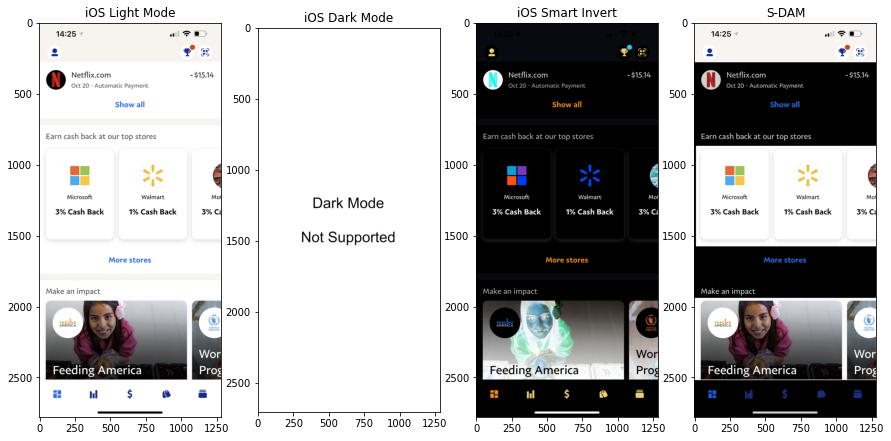

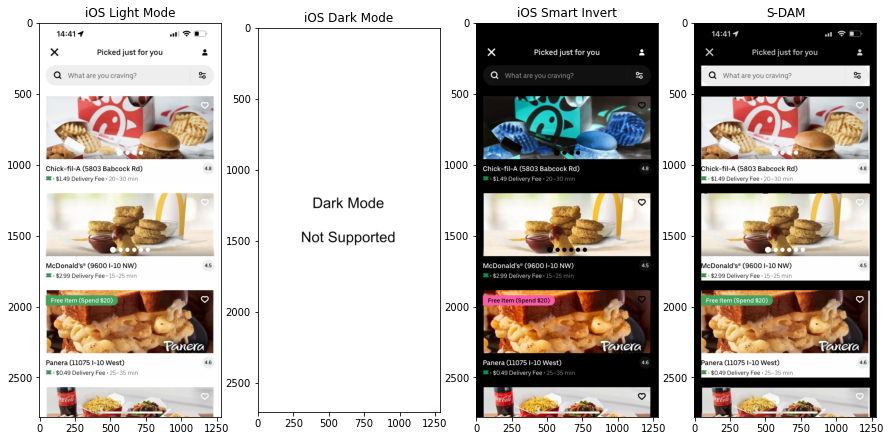

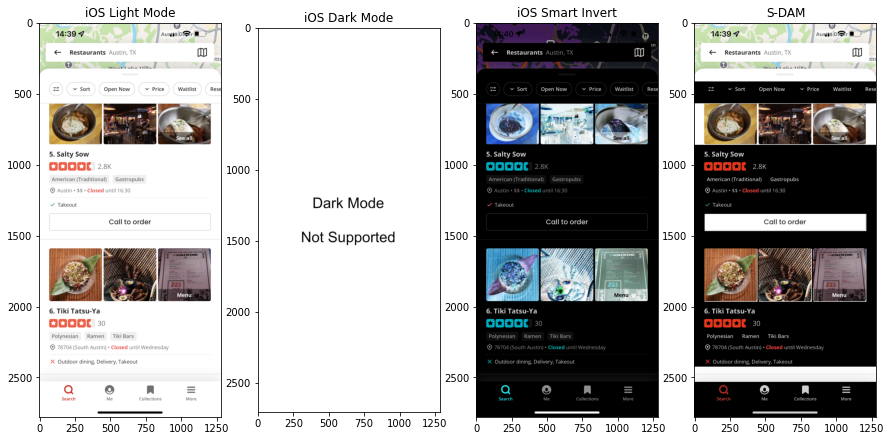

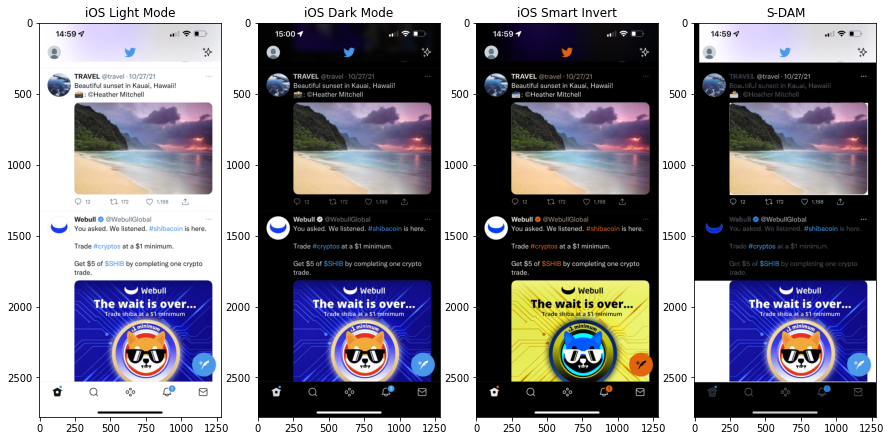

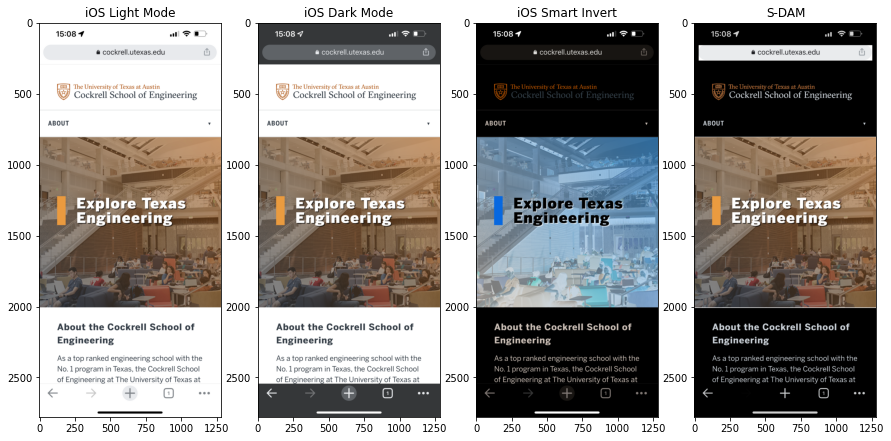

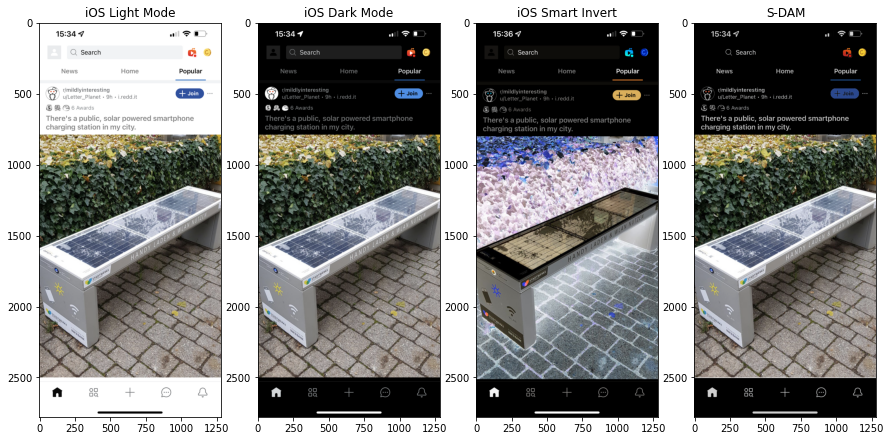

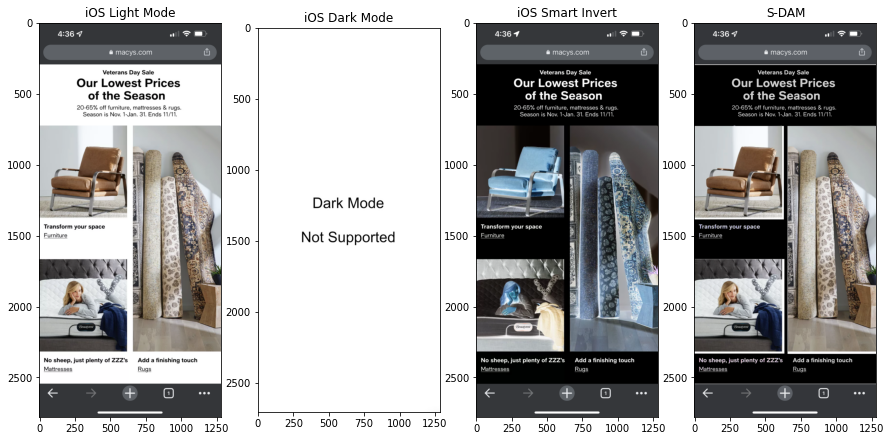

In [7]:
smartContrastImage('./screens/04_paypal_original.png','./screens/11_darkmode_default.jpeg','./screens/04_paypal_smartinvert.png') 
smartContrastImage('./screens/06_ubereats_original.png','./screens/11_darkmode_default.jpeg','./screens/06_ubereats_smartinvert.png') 
smartContrastImage('./screens/05_yelp_original.png','./screens/11_darkmode_default.jpeg','./screens/05_yelp_smartinvert.png',) 
smartContrastImage('./screens/07_twitter_original.png','./screens/07_twitter_darkmode.png','./screens/07_twitter_smartinvert.png') 
smartContrastImage('./screens/08_chrome_original.png','./screens/08_chome_darkmode.png','./screens/08_chrome_smartinvert.png') 
smartContrastImage('./screens/09_reddit_original.png','./screens/09_reddit_darkmode.png','./screens/09_reddit_smartinvert.png') 
smartContrastImage('./screens/10_chrome_macys_original.png','./screens/11_darkmode_default.jpeg','./screens/10_chrome_macys_smartinvert.png') 